In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [45]:
df = pd.read_pickle("../../data/vel_LR_ssh.pkl")

# Extracting information

In [46]:
df["mean"] = ""
df["std"] = ""
df["kurtosis"] = ""
df["skewness"] = ""
df["max"] = ""
df["min"] = ""
df["crest factor"] = ""
df["rms"] = ""
df["shape factor"] = ""
df["pump label"] = ""

In [47]:
df["mean"] = df["ts"].apply(lambda ts: [np.nanmean(ts) for ts in ts])
df["std"] = df["ts"].apply(lambda ts: [np.nanstd(ts) for ts in ts])
df["kurtosis"] = df["ts"].apply(
    lambda ts: [sc.stats.kurtosis(ts, nan_policy="omit") for ts in ts]
)
df["skewness"] = df["ts"].apply(
    lambda ts: [sc.stats.skew(ts, nan_policy="omit") for ts in ts]
)
df["max"] = df["ts"].apply(lambda ts: [np.nanmax(ts) for ts in ts])
df["min"] = df["ts"].apply(lambda ts: [np.nanmin(ts) for ts in ts])
df["rms"] = df["ts"].apply(lambda ts: [np.sqrt(np.nanmean(ts**2)) for ts in ts])
df["crest factor"] = df["ts"].apply(
    lambda ts: [np.nanmax(ts) / (np.sqrt(np.nanmean(ts**2))) for ts in ts]
)
df["shape factor"] = df["ts"].apply(
    lambda ts: [np.sqrt(np.nanmean(ts**2)) / np.nanmean(abs(ts)) for ts in ts]
)

In [48]:
# 1 --> has pump problem
# 0 --> doesn't have pump problem

for i, row in df.iterrows():
    if "Pump_Flow_Problem." in row["faults"]:
        df.loc[i, "pump label"] = "1"
    else:
        df.loc[i, "pump label"] = "0"

In [49]:
df.head()

ts status  \
0  [[-0.000182507, -0.000762011, -0.00155276, -0....     l2   
1  [[-0.004772555, -0.004103458, -0.003247749, -0...     l1   
2  [[-0.002188359, -0.002100263, -0.001989596, -0...     l1   
3  [[-0.000954767, -0.001490966, -0.001977236, -0...     l1   
4  [[-0.002692016, -0.002709083, -0.001516245, -0...     l2   

                                              faults            machine_name  \
0  [Machine_Misalignment., Motor_Bearings_Fault.,...  concvacpump6.1301A-VLR   
1  [Machine_Misalignment., Motor_Bearings_Fault.,...  concvacpump6.1301A-VLR   
2  [Machine_Misalignment., Motor_Bearings_Fault.,...  concvacpump6.1301A-VLR   
3  [Machine_Misalignment., Motor_Bearings_Fault.,...  concvacpump6.1301A-VLR   
4  [Machine_Misalignment., Motor_Bearings_Fault.,...  concvacpump6.1301A-VLR   

           report_date          portal_date  \
0  2021-01-18 00:00:00  2021-01-18 00:00:00   
1  2021-12-27 00:00:00  2021-12-27 00:00:00   
2  2020-11-25 00:00:00  2020-11-25 00:00:00   
3  2022-04-24 00:00:00  2022-04-24 00:00:00   
4  2022-02-20 00:00:00  2022-02-20 00:00:00   

                                                mean  \
0  [-3.693769531249949e-07, 4.006253747558593e-05...   
1  [-1.3931111083984377e-05, -3.631303271484375e-...   
2  [-1.6181146484375014e-05, -9.722639404296867e-...   
3  [-8.46498706054688e-06, 6.83683276367188e-06, ...   
4  [-2.064112377929688e-05, -1.758539238281251e-0...   

                                                 std  \
0  [0.0018601822443232992, 0.0030175169268431986,...   
1  [0.0019259116189656732, 0.0030257832200305023,...   
2  [0.0017577013478103512, 0.002471256059770926, ...   
3  [0.0018952110311943678, 0.002566903232677748, ...   
4  [0.0018659769482993118, 0.0030752896627928117,...   

                                            kurtosis  \
0  [-0.013298541361706384, 0.0103195173985009, 0....   
1  [-0.09989669497028641, -0.10435893842016242, -...   
2  [0.25325601970799694, 0.37783805646147206, -0....   
3  [-0.1619832427977541, -0.10431581057676986, -0...   
4  [-0.06603416387451588, -0.32635594187090344, -...   

                                            skewness  \
0  [-0.0783611287026034, 0.07773887594599543, 0.0...   
1  [0.06057246335021553, 0.11146549597389545, -0....   
2  [-0.06625157707656007, -0.1509033030743881, -0...   
3  [-0.021187067878208485, 0.016128282412632186, ...   
4  [0.04911502961372701, 0.06285251168811878, 0.0...   

                                                 max  \
0  [0.006780835, 0.009969162, 0.027541114, 0.0055...   
1  [0.00606685, 0.010458384, 0.010843489, 0.00651...   
2  [0.005707427, 0.008852553, 0.011653647, 0.0073...   
3  [0.006087945, 0.010119365, 0.010637392, 0.0073...   
4  [0.006078278, 0.009865044, 0.01310216, 0.00808...   

                                                 min  \
0  [-0.007168011, -0.011624384, -0.029277566, -0....   
1  [-0.007177491, -0.010179518, -0.009987765, -0....   
2  [-0.00630873, -0.00858779, -0.011364505, -0.00...   
3  [-0.006392286, -0.008418323, -0.010461427, -0....   
4  [-0.006225085, -0.008604529, -0.011552138, -0....   

                                        crest factor  \
0  [3.6452529783080614, 3.303472267959477, 3.7530...   
1  [3.1500361835588215, 3.4561732174770547, 3.193...   
2  [3.246959545518821, 3.5821801844627266, 3.3816...   
3  [3.2122461162455545, 3.942232405959796, 2.9864...   
4  [3.257224671539588, 3.207789768769835, 2.97142...   

                                                 rms  \
0  [0.0018601822809969457, 0.0030177828634105216,...   
1  [0.0019259620037589047, 0.0030260011121880153,...   
2  [0.001757775826889161, 0.0024712751855411625, ...   
3  [0.0018952299355927116, 0.0025669123374618213,...   
4  [0.001866091109130335, 0.003075339941552085, 0...   

                                        shape factor pump label  
0  [1.252536060367827, 1.25372484721787, 1.252103...          0  
1  [1.2497316396382447, 1.247110898169471, 1.2216...          1  
2  [1.2684403

# Adjusting the data to be trained on

In [50]:
training_cols = [
    "mean",
    "std",
    "kurtosis",
    "skewness",
    "max",
    "min",
    "crest factor",
    "rms",
    "shape factor",
]

In [51]:
all_data = np.stack(
    [np.array(df[col].apply(lambda x: x[-6:])).tolist() for col in training_cols],
    axis=1,
)

In [52]:
all_data = torch.tensor(all_data, dtype=float)

In [53]:
y = torch.tensor(df["pump label"].values.astype(float)).view(-1, 1)

In [54]:
reshaped_data = all_data.view(all_data.shape[0], -1)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    reshaped_data, y, test_size=0.2, random_state=42
)

# Building the model

In [56]:
class ANN_model(nn.Module):
    def __init__(self, input_size=54, output_size=1, layers=[25, 10]):
        super().__init__()
        self.fc1 = nn.Linear(input_size, layers[0])
        self.dropout = nn.Dropout()
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))

        return x

* Defining optimizer and loss function

In [57]:
torch.manual_seed(42)
model = ANN_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

# Training

In [58]:
#saving results
losses = []
epochs = 25

for i in range(epochs):
    y_train_predicted = model(X_train.float())
    loss = criterion(y_train_predicted, y_train.float())
    losses.append(loss)

    y_train_predicted_binary = (y_train_predicted > 0.5).float()
    accuracy = accuracy_score(y_train, y_train_predicted_binary)

    print(f"epoch: {i:2} loss: {loss.item():10.8f}    accuracy: {accuracy * 100:.2f}%")
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch:  0 loss: 0.68604362   accuracy: 61.08%
epoch:  1 loss: 0.64978057   accuracy: 75.68%
epoch:  2 loss: 0.63574332   accuracy: 76.22%
epoch:  3 loss: 0.61377954   accuracy: 77.30%
epoch:  4 loss: 0.59312969   accuracy: 77.30%
epoch:  5 loss: 0.57762963   accuracy: 77.30%
epoch:  6 loss: 0.59810942   accuracy: 77.30%
epoch:  7 loss: 0.58638734   accuracy: 77.30%
epoch:  8 loss: 0.58079237   accuracy: 77.30%
epoch:  9 loss: 0.59255022   accuracy: 77.30%
epoch: 10 loss: 0.58284777   accuracy: 77.30%
epoch: 11 loss: 0.54940510   accuracy: 77.30%
epoch: 12 loss: 0.53072751   accuracy: 77.30%
epoch: 13 loss: 0.54905617   accuracy: 77.30%
epoch: 14 loss: 0.55748087   accuracy: 77.30%
epoch: 15 loss: 0.54923350   accuracy: 77.30%
epoch: 16 loss: 0.54512858   accuracy: 77.30%
epoch: 17 loss: 0.55924737   accuracy: 77.30%
epoch: 18 loss: 0.56268054   accuracy: 77.30%
epoch: 19 loss: 0.52592027   accuracy: 77.30%
epoch: 20 loss: 0.51829791   accuracy: 77.30%
epoch: 21 loss: 0.52241725   accur

# Validating

loss: 0.65359390   accuracy: 65.96%


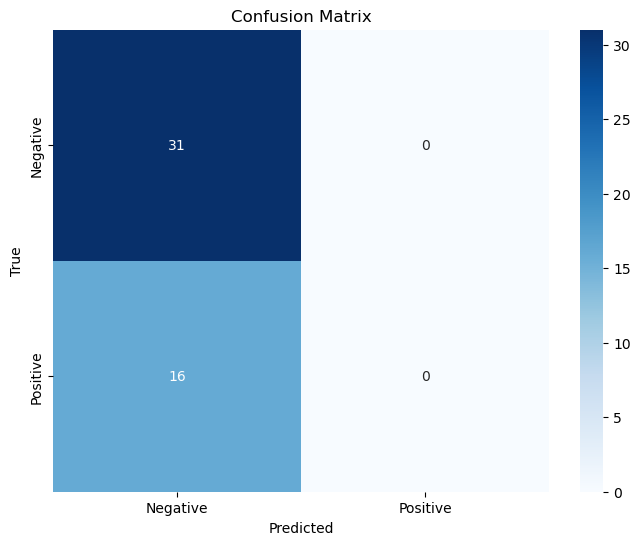

In [59]:
with torch.no_grad():
    y_test_predicted = model(X_test.float())
    loss = criterion(y_test_predicted, y_test.float())

    y_test_predicted_binary = (y_test_predicted > 0.5).float()
    accuracy = accuracy_score(y_test, y_test_predicted_binary)

    print(f"loss: {loss.item():10.8f}   accuracy: {accuracy * 100:.2f}%")
    cm = confusion_matrix(y_test, y_test_predicted_binary)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Negative", "Positive"],
        yticklabels=["Negative", "Positive"],
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

* ploting loss After each epoch

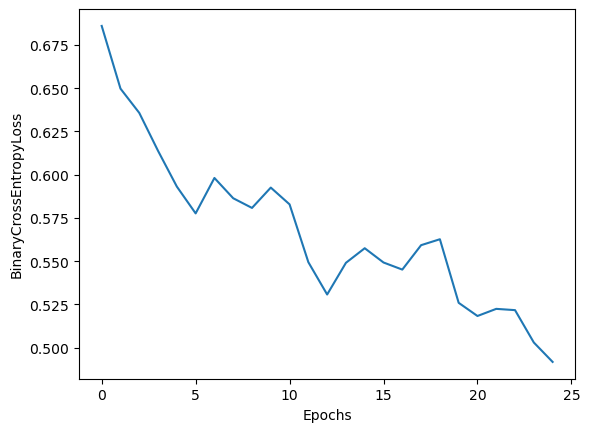

In [60]:
with torch.no_grad():
    plt.plot(losses)
    plt.xlabel("Epochs")
    plt.ylabel("BinaryCrossEntropyLoss")